1. 데이터 불러오기/변환
2. Text자료 가공
  1. 부정리뷰 추이
  2. Wordcloud
  3. 주요단어(top 30)
  4. 연관단어(keyword 기준)
  5. 특이리뷰(요청한 키워드가 포함된 내용)
3. 이메일 양식 작성

In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# from konlpy.tag import Okt
# okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 분석1 : Trend 탐식 시, 이상치 확인
from sklearn.neighbors import LocalOutlierFactor

# 분석2 : wordcloud 준비
from wordcloud import WordCloud

# 분석3 : text rank 도출
import itertools
import nltk

# 시간기록
from datetime import datetime, timedelta
import time 

# 내용공유(e-mail, 회사) 
# import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [2]:
# 제품군 정보
category_group = '곡물음료'

category = [['아몬드브리즈', '비리다'],
            ['아몬드브리즈', '냄새'  ],
            ['아몬드브리즈', '맛없다'],
            ['두유', '맛없다'],
            ['두유', '달다'  ],
            ['두유', '파손'  ] ]

# 발송 변수 설정
# 받는사람 : mulit 발송
# to_users = ['khpark@maeil.com', '*******@maeil.com', '*******@maeil.com', '*******@maeil.com']

# 받는사람 : test 발송
to_users = ['khpark@maeil.com']

### I.데이터 불러오기

In [3]:
# 제품군 정보
df_product = pd.read_excel('./PRODUCT.xlsx','Sheet1')
df_product['PRODUCT_CODE'] = df_product['PRODUCT_CODE'].astype(object)
df_product = df_product[df_product['category1'] == category_group ]

In [4]:
query_values = tuple(df_product.PRODUCT_CODE.to_list())
query_values = str(query_values)

In [5]:
#########
# rawdata 불러오기
###

# DB연결
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)


In [6]:
# 쿼리실행: 전체리뷰
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집채널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in ''' + query_values + ''' and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 14 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT
        '''
cursor.execute(sql)
df_review_all = cursor.fetchall()
df_review_all = pd.DataFrame(df_review_all)
df_review_all['리뷰등록일'] = pd.to_datetime(df_review_all['리뷰등록일'])
df_review_all = df_review_all.join(df_product.set_index('상품명')['category2'], on='상품명')

df_review_all = df_review_all[df_review_all.columns[2:]].drop_duplicates().reset_index(drop=True)

In [7]:
# df_review_all.tail(15)

In [8]:
# 부정 리뷰
df_review_neg= df_review_all[(df_review_all['구매자평점']=='1')|(df_review_all['구매자평점']=='2')]

In [9]:
df_review_neg

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2
1124,1,고소하지도 않고 진하지도 않네요,2021-07-21,3 네이버,두유
1273,2,맛은 그닥이에요........ㅜ,2021-07-21,3 네이버,아몬드브리즈
1771,1,배송이 한번오고 안오네요\n연락도없고,2021-07-22,3 네이버,두유
2708,1,평소 제품크게 문제 없이 왔는데 이번에는 터져왔네요,2021-07-23,4 SSG닷컴,두유
3254,1,배송 진짜 최악이네요\n다 열려서 왔어요\n터진건 없지만 찌그러져있구요\n음식인데 ...,2021-07-24,3 네이버,아몬드브리즈
3701,2,저당이어서 시켰는데 제 입맛에는 별루네영.... 다음에는 다른 맛 시키려구용 ....ㅎ,2021-07-25,3 네이버,두유
5468,2,뭐 늘 믿고 먹는 아몬드브리즈인데요. 열 개 중에 세 개가 터져서 왔습니다\n저렇게...,2021-07-28,3 네이버,아몬드브리즈
5865,1,배송이 너무 느렸어요,2021-07-28,3 네이버,아몬드브리즈
6285,1,이런적 처음입니다. 배송 받아 4통 마시고 새로운 거 꺼내려고 보니 빵빵하게 부풀어...,2021-07-29,3 네이버,두유
6632,2,너무 물 같아요 콩물,2021-07-30,4 SSG닷컴,두유


In [53]:
# 쿼리실행
sql= '''select (SELECT code_nm FROM JT_CODE B WHERE left(A.PRODUCT_CODE,6) =B.CODE AND B.CODE_GRP_ID = 'PRODUCT') "상품명"
        , (SELECT left(code_nm,1) FROM JT_CODE B WHERE A.CS_GUBUN = B.CODE AND B.CODE_GRP_ID = 'CS_GUBUN') "CS유형"
        , (SELECT code_nm FROM JT_CODE B WHERE A.CS_GUBUN = B.CODE AND B.CODE_GRP_ID = 'CS_GUBUN') "CS유형_상세"
        , (STR_TO_DATE(A.INS_DM, '%Y%m%d')) as 인입일자 
        from MAEIL_CS A
        where PRODUCT_CODE in ''' + query_values + ''' 
        and DATE_FORMAT(substr(INS_DM, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 14 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        '''
cursor.execute(sql)
df_logistic = cursor.fetchall()
df_logistic = pd.DataFrame(df_logistic)
df_logistic['인입일자'] = pd.to_datetime(df_logistic['인입일자'])
df_logistic = df_logistic.join(df_product.set_index('상품명')['category2'], on='상품명')

In [54]:
df_logistic.head(2)

,상품명,CS유형,CS유형_상세,인입일자,category2
0,멸균 매일두유 [ 고단백 ] [ 190ml ],9,905] 품절,2021-07-26,두유
1,멸균 매일두유 [ 고단백 ] [ 190ml ],2,202] 배송누락(출고누락 등),2021-07-15,두유


In [86]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [87]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all['token'] = df_temp1
df_review_all['token_attribution'] = token_all


In [88]:
#토큰화 : 부정리뷰자료
df_temp2 = df_review_neg['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_neg = [tokenize(row) for row in df_temp2 ]  

data_trim2 = []
for i in range(len(df_temp2)):
    t = ' '.join(token_neg[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp2 = pd.DataFrame(data_trim2)
df_temp2 = df_temp2[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_neg['token'] = df_temp2
df_review_neg['token_attribution'] = token_neg

In [89]:
# 중간확인
# df_temp.drop_duplicates()
# df_temp[104]
# data_trim2[104]

### III.데이터 리포팅

In [61]:
# df_product[df_product['category1'] =='셀렉스']

#### 1.제품 현황

In [91]:
###############
# 리포트용 자료 만들기 : 1.제품 현황
#####

# 자료 정렬
df_temp1 = pd.DataFrame(df_review_all.groupby(['category2'])['리뷰등록일'].count())
df_temp1.rename(columns = { '리뷰등록일' : '전체리뷰(1~5)' }, inplace = True)

df_temp2 = pd.DataFrame(df_review_neg.groupby(['category2'])['리뷰등록일'].count())
df_temp2.rename(columns = { '리뷰등록일' : '부정리뷰(1~2)' }, inplace = True)

df_temp3 = pd.DataFrame(df_logistic.groupby(['category2'])['인입일자'].count())
df_temp3.rename(columns = { '인입일자' : 'CS문의' }, inplace = True)

# 자료 합치기
report_01 = df_temp1.merge(df_temp2, how='left', on=['category2']).fillna(0)
report_01 = report_01.merge(df_temp3, how='left', on=['category2']).fillna(0)

pd.options.display.float_format = '{:0,.0f}'.format


In [92]:
report_01

,전체리뷰(1~5),부정리뷰(1~2),CS문의
category2,,,
두유,4248,9,178
아몬드브리즈,4394,6,197


#### 1.부정리뷰 추이 + word cloud

In [93]:
###############
# 리포트용 자료 만들기 : 2.Trend &  Wordcloud
#####

# word cloud 생성
def wordcloud_gen(dataset):
    text = dataset.to_list()
    text_all = listToString(text)
    wc1 = WordCloud(font_path= path, stopwords = stopword, width = 900, height = 600, background_color="white", repeat=True)
    return wc1.generate(text_all)

In [107]:
stopword = ['먹다', '하다', '좋다'  , '예요', '이에요', '있다', '맛있다', '같다', '없다', '보통', '최고', '주문', '보다', '매일',
         '구매', '에서', '먹이다', '않다', '자다'  , '들다', '사다'  , '되다', '으로', 'ㅠㅠ', 'ㅜㅜ', '말다', '이다', '받다',
         '아직', '이다', '보이다', '이나', '오다'  , '이라', '우유'  , '배달', '배송', '가정', '제품', '신청', '문의', '되어다',
         '넘다', 'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', '진짜'  , '너무', '이', '는', '요', '은', '에', '기', '다', '도', '원', '구', '개', '랑','가',
         '도', '임시', '이미지', '확인', '후', '을', '안' ,'되다', '하', '심', '고객', '님', '어요', '좀', '것', '니', '어보', '타',
         '생각', '지만', '잘', '제', '니다', '네', '해', '그래도', '엄청', '하고', '번', '그', '나다', '시', '다가', '한', '해서', '로',
         '더', '못', '에는', '던데', '일단', '나요', '아하', '이적','이고', '려고', '이라고', '고', '어서','를', '그냥', '만', '짧다',
         '유통기한', '인데', '박스', '까지', '일', '월', '두', '팩','어요', '요','다', '한', '있다', '라', '나', '게', '거', '데',
         '더니','달', '보', '이번', '이네', '내주', '하나', '수', '저', '이렇다', '이렇게', 'ㅠ', '때', '늘', '또', '편', '늘','감사',
         '항상', '여', '아해', '들', '중', '열', '영', '분', '세', '뭐', '루', '알', '용'
         ]

In [95]:
# Trend 자료 생성
trend_review_all = pd.pivot_table(df_review_all, index = '리뷰등록일', values = '리뷰상세내용', columns = '구매자평점', aggfunc = 'count').fillna(0)
trend_claim_all = pd.pivot_table(df_logistic, values='CS유형_상세', index='CS유형',columns=['인입일자'], aggfunc="count").fillna(0)

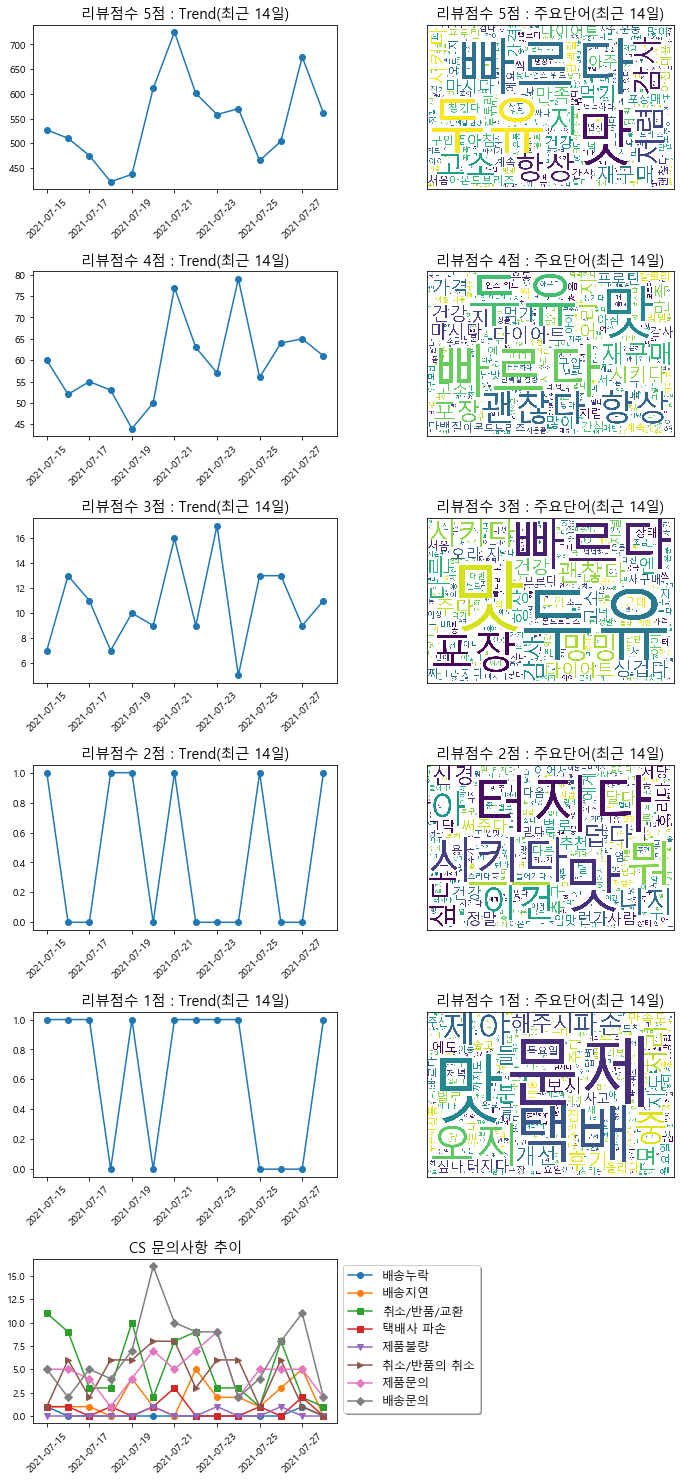

In [96]:
# 그래프 생성
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_cs_Trend_graph.png'

plt.figure(figsize=(12, 50))

plt.subplot(12,2,1)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(trend_review_all.T.iloc[[4]].T[0:],  marker="o" )
plt.xticks(rotation=45)
plt.title('리뷰점수 5점 : Trend(최근 14일)',fontsize='x-large')

plt.subplot(12,2,2)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '5']['token']), cmap=plt.cm.binary)
plt.title('리뷰점수 5점 : 주요단어(최근 14일)',fontsize='x-large')


plt.subplot(12,2,3)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(trend_review_all.T.iloc[[3]].T[0:],  marker="o" )
plt.xticks(rotation=45)
plt.title('리뷰점수 4점 : Trend(최근 14일)',fontsize='x-large')

plt.subplot(12,2,4)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '4']['token']), cmap=plt.cm.binary)
plt.title('리뷰점수 4점 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(12,2,5)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(trend_review_all.T.iloc[[2]].T[0:],  marker="o" )
plt.xticks(rotation=45)
plt.title('리뷰점수 3점 : Trend(최근 14일)',fontsize='x-large')

plt.subplot(12,2,6)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '3']['token']), cmap=plt.cm.binary)
plt.title('리뷰점수 3점 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(12,2,7)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(trend_review_all.T.iloc[[1]].T[0:],  marker="o" )
plt.xticks(rotation=45)
plt.title('리뷰점수 2점 : Trend(최근 14일)',fontsize='x-large')

plt.subplot(12,2,8)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '2']['token']), cmap=plt.cm.binary)
plt.title('리뷰점수 2점 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(12,2,9)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(trend_review_all.T.iloc[[0]].T[0:],  marker="o" )
plt.xticks(rotation=45)
plt.title('리뷰점수 1점 : Trend(최근 14일)',fontsize='x-large')

plt.subplot(12,2,10)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '1']['token']), cmap=plt.cm.binary)
plt.title('리뷰점수 1점 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(12,2,11)
plt.plot(trend_claim_all.iloc[[0]].T[0:],  marker="o", label='배송누락')
plt.plot(trend_claim_all.iloc[[1]].T[0:],  marker="o", label='배송지연')
plt.plot(trend_claim_all.iloc[[2]].T[0:],  marker="s", label='취소/반품/교환')
plt.plot(trend_claim_all.iloc[[3]].T[0:],  marker="s", label='택배사 파손')
plt.plot(trend_claim_all.iloc[[4]].T[0:],  marker="v", label='제품불량')
plt.plot(trend_claim_all.iloc[[5]].T[0:],  marker=">", label='취소/반품의 취소')
plt.plot(trend_claim_all.iloc[[6]].T[0:],  marker="D", label='제품문의')
plt.plot(trend_claim_all.iloc[[7]].T[0:],  marker="D", label='배송문의')
# plt.plot(trend_claim_all.iloc[[8]].T[0:],  marker="D", label='기타')
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=45)
plt.title('CS 문의사항 추이',fontsize='x-large')

# plt.savefig(image_name, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=70)

plt.show()

#### 3.주요단어(top 30) 

이슈사항
  + [ ] filtering 설정

In [97]:
###############
# 리포트용 자료 만들기 : 3. 주요단어 Rank
#####

# 날짜 지정
termA_start = (df_review_all.리뷰등록일.max() - timedelta(days=7)).strftime('%Y-%m-%d')
termA_end   = (df_review_all.리뷰등록일.max()).strftime('%Y-%m-%d')
termB_start = (df_review_all.리뷰등록일.min()).strftime('%Y-%m-%d')
termB_end   = (df_review_all.리뷰등록일.min()+  timedelta(days=7)).strftime('%Y-%m-%d')


# 자료가공
df_review_all_termA = df_review_all[df_review_all.리뷰등록일.between(termA_start, termA_end)]
df_review_all_termB = df_review_all[df_review_all.리뷰등록일.between(termB_start, termB_end)]
df_review_neg_termA = df_review_neg[df_review_neg.리뷰등록일.between(termA_start, termA_end)]
df_review_neg_termB = df_review_neg[df_review_neg.리뷰등록일.between(termB_start, termB_end)]


list_all_termA = list(itertools.chain(*df_review_all_termA.token_attribution))
list_all_termB = list(itertools.chain(*df_review_all_termB.token_attribution))
list_neg_termA = list(itertools.chain(*df_review_neg_termA.token_attribution))
list_neg_termB = list(itertools.chain(*df_review_neg_termB.token_attribution))


def wordrank(dataset):
    ko = nltk.Text(dataset)
    
    data = ko.vocab().items()
    reviw_word_all = pd.DataFrame.from_dict(data)
    reviw_word_all.rename(columns = { 1 : 'count' }, inplace = True)
    reviw_word_all = reviw_word_all.sort_values('count', ascending=False)
    reviw_word_all['속성'] =reviw_word_all[0].str.split('/').str[1]
    reviw_word_all['내용'] =reviw_word_all[0].str.split('/').str[0]

    # stopword 내용 삭제
    reviw_word_all = reviw_word_all[~reviw_word_all.내용.isin(stopword)]

    # 일부 속성 삭제
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Punctuation')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Josa')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Foreign')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'KoreanParticle')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Number')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Adverb')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Exclamation')]

    # top15 만 지정
    reviw_word_all = reviw_word_all[['속성', '내용', 'count']].head(15)

    return reviw_word_all


In [108]:
wordrank_all_termA = wordrank(list_all_termA)
wordrank_all_termA['기간구분'] = '1주전(A)'
wordrank_all_termA['리뷰유형'] = '전체'
wordrank_all_termA['RANK'] = wordrank_all_termA['count'].rank(ascending = False)


wordrank_all_termB = wordrank(list_all_termB)
wordrank_all_termB['기간구분'] = '2주전(B)'
wordrank_all_termB['리뷰유형'] = '전체'
wordrank_all_termB['RANK'] = wordrank_all_termB['count'].rank(ascending = False)


wordrank_neg_termA = wordrank(list_neg_termA)
wordrank_neg_termA['기간구분'] = '1주전(A)'
wordrank_neg_termA['리뷰유형'] = '부정'
wordrank_neg_termA['RANK'] = wordrank_neg_termA['count'].rank(ascending = False)


wordrank_neg_termB = wordrank(list_neg_termB)
wordrank_neg_termB['기간구분'] = '2주전(B)'
wordrank_neg_termB['리뷰유형'] = '부정'
wordrank_neg_termB['RANK'] = wordrank_neg_termB['count'].rank(ascending = False)


wordrank_all = pd.concat([wordrank_all_termA, wordrank_all_termB])
wordrank_neg = pd.concat([wordrank_neg_termA, wordrank_neg_termB])

# wordrank_total = pd.concat([wordrank_all, wordrank_neg])

REPORT_03 =  pd.pivot_table(wordrank_all, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min).fillna('')
REPORT_04 =  pd.pivot_table(wordrank_neg, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min).fillna('')


In [109]:
result_rank = []
for i in range(len(REPORT_03)):
    if REPORT_03[REPORT_03.columns[-2]][i] != '':
        try:
            rank_diff = REPORT_03[REPORT_03.columns[-2]][i] - REPORT_03[REPORT_03.columns[-1]][i]
            if REPORT_03[REPORT_03.columns[-2]][i] - REPORT_03[REPORT_03.columns[-1]][i] > 0:
                result_rank.append('📉down') 
            elif REPORT_03[REPORT_03.columns[-2]][i] - REPORT_03[REPORT_03.columns[-1]][i] < 0:
                result_rank.append('📈up') 
            elif REPORT_03[REPORT_03.columns[-2]][i] - REPORT_03[REPORT_03.columns[-1]][i] == 0:
                result_rank.append('-') 
        except:
            result_rank.append('✔NEW')
    else:
        result_rank.append('💬out')
REPORT_03['증감(A-B)'] = result_rank


result_rank = []
for i in range(len(REPORT_04)):
    if REPORT_04[REPORT_04.columns[-2]][i] != '':
        try:
            rank_diff = REPORT_04[REPORT_04.columns[-2]][i] - REPORT_04[REPORT_04.columns[-1]][i]
            if REPORT_04[REPORT_04.columns[-2]][i] - REPORT_04[REPORT_04.columns[-1]][i] > 0:
                result_rank.append('⬇') 
            elif REPORT_04[REPORT_04.columns[-2]][i] - REPORT_04[REPORT_04.columns[-1]][i] < 0:
                result_rank.append('🔺') 
            elif REPORT_04[REPORT_04.columns[-2]][i] - REPORT_04[REPORT_04.columns[-1]][i] == 0:
                result_rank.append('-') 
        except:
            result_rank.append('✔NEW')
    else:
        result_rank.append('out')
        
REPORT_04['증감(A-B)'] = result_rank


In [110]:
REPORT_03

기간구분,1주전(A),2주전(B),증감(A-B)
내용,,,
건강,14,,✔NEW
고소,6,7,📈up
다이어트,12,9,📉down
단백질,5,4,📉down
대용,,14,💬out
두유,2,2,-
마시다,15,15,-
만족,9,13,📈up
맛,1,1,-


In [111]:
REPORT_04

기간구분,1주전(A),2주전(B),증감(A-B)
내용,,,
개선,,8,out
다른,1,,✔NEW
다음,1,,✔NEW
들어가다,1,,✔NEW
뚫리다,1,,✔NEW
맛,3,1,⬇
문제,,8,out
믿다,1,,✔NEW
별,1,,✔NEW


In [118]:
category = [['아몬드브리즈', '비리다'],
            ['아몬드브리즈', '냄새'  ],
            ['아몬드브리즈', '맛없다'],
            ['아몬드브리즈', '밍밍'],
            ['두유', '비리다'],
            ['두유', '냄새'  ], 
            ['두유', '맛없다'],
            ['두유', '밍밍'  ],
            ['두유', '달다'  ] ]

In [125]:
###############
# 리포트용 자료 만들기 : 5.키워드별 rawdata
#####

data_by_keyword = pd.DataFrame()

category_count = []
for text1 ,text2 in category :
    df_sort = df_review_all[(df_review_all['token'].str.contains(str(text2)))]
    df_sort = df_sort[(df_sort['category2'].str.contains(str(text1)))][['리뷰등록일','수집채널','리뷰상세내용','구매자평점', 'category2']]
    df_sort = df_sort.drop_duplicates()
    if len(df_sort) > 0:
        df_sort['키워드'] = text2
        category_count.append(len(df_sort))
        data_by_keyword = pd.concat([df_sort, data_by_keyword]).reset_index() 
    else:
        category_count.append(int(0))
        
report_05 = pd.DataFrame(category)
report_05 = report_05.rename(columns={0: "Category", 1: "키워드"})
report_05['리뷰개수_중복포함'] = category_count

In [126]:
report_05

,Category,키워드,리뷰개수_중복포함
0,아몬드브리즈,비리다,1
1,아몬드브리즈,냄새,2
2,아몬드브리즈,맛없다,15
3,아몬드브리즈,밍밍,49
4,두유,비리다,21
5,두유,냄새,1
6,두유,맛없다,10
7,두유,밍밍,37
8,두유,달다,82


In [151]:
data_by_keyword2 = data_by_keyword.reset_index()

In [152]:
len(data_by_keyword2)

218

In [145]:
# 모델 불러오기/활용
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

def sentiment_predict(new_sentence, max_len = 80):
    new_sentence = twitter.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopword] # 불용어 제거
    with open('./model/210729_tokenizer(GRU).pickle', 'rb') as handle:
        tokenizer = pickle.load(handle) # 사전 불러오기
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    loaded_model = tf.keras.models.load_model('./model/210729_NPL_best_model(GRU)_v2.h5')
    score = float(loaded_model.predict(pad_new)) # 예측
    score = round(score/2 * 10,2)
#     print("리뷰점수 {:.2f}".format(score))
    return score

In [157]:
%%time
score_modeling = []
for i in range(len(data_by_keyword2)):
    try:
        score_temp = sentiment_predict(data_by_keyword['리뷰상세내용'][i])
        score_modeling.append(score_temp)
    except:
        score_modeling.append('0')

Wall time: 5min 18s


In [154]:
data_by_keyword2['score_조정'] = score_modeling

In [155]:
data_by_keyword2

,level_0,index,리뷰등록일,수집채널,리뷰상세내용,구매자평점,category2,키워드,score_조정
0,0,160,2021-07-15,3 네이버,달지않은 두유먹다가 주문했는데 생각보다 많이 달아요.,4,두유,달다,2
1,1,162,2021-07-15,3 네이버,유통기한도 적당하고 맛도 좋네요\n쵸코우유보다 덜 달아요,4,두유,달다,5
2,2,165,2021-07-15,3 네이버,이거 먹으니 다른건 못 먹겠어요ㅋㅋㅋ 너무 맛있어요\n초코우유에 비해 덜 달아서 좋아요,5,두유,달다,2
3,3,178,2021-07-15,3 네이버,포장은 이 상태에서 딱 맞는 박스에 담겨 옵니다. 항상 먹는 제품이라 잘 먹고 있습...,5,두유,달다,5
4,4,194,2021-07-15,3 네이버,성분 좋고 안 달아서 먹기 좋아요!,4,두유,달다,1
...,...,...,...,...,...,...,...,...,...
213,213,8067,2021-07-28,3 네이버,처음에 먹을때는 단맛에 길들여져있어서 맛없었는데 지금은 먹을만하네요ㅋ,5,아몬드브리즈,맛없다,1
214,214,8528,2021-07-28,3 네이버,역시 아몬드브리즈~~~맛없는라인이없어요~^^\n이번에 식이섬유 나왔길래 가격도착하고...,5,아몬드브리즈,맛없다,0
215,215,3680,2021-07-21,3 네이버,처음에는 냄새가 익숙하지 않았는데 먹을수록 가볍고 맛있어요. 냉장고에 떨어지지 않게...,5,아몬드브리즈,냄새,4
216,216,5401,2021-07-23,3 네이버,사은품과 같이 배송되었어요\n드라이백만 구입하려해도 몇만원하는데^^\n품질도 좋고 ...,5,아몬드브리즈,냄새,0


In [156]:
# Excel 저장
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2[2:] +'_' +category_group +'_report.xlsx'
data_by_keyword2.to_excel(excel_name, sheet_name= 'Sheet1' )